# Tutorial sencillo de aprendizaje automático : corrección

## Ejemplo: predicción de daños sísmicos en edificios

Sophie Giffard-Roisin (sophie.giffard@univ-grenoble-alpes.fr)

## Introducción

Esta es una sencilla introducción al aprendizaje automático para que conozca su funcionamiento.

Utilizaremos un conjunto de datos reales sobre daños en edificios, cuyo objetivo es estimar el grado de daño de un edificio a partir de sus características (material de construcción, número de plantas, etc.) y de la intensidad del movimiento del suelo. Este conjunto de datos procede del estudio sobre el terremoto de Nepal de 2015 (gracias a Subash Ghimire y Philippe Gueguen por dar acceso a los datos).
<img src="imgs/damage_grades.png" width="50%">
<div style="text-align: center">Objetivo de la base de datos: grados de daños en los edificios identificados tras el terremoto de Nepal de 2015. Entrada del conjunto de datos: características del edificio (material de construcción, número de plantas, etc.) y la intensidad efectiva del movimiento del suelo en este lugar. (Créditos: Yalda Saedi)</div>



In [1]:
%matplotlib inline
import os
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd

## A. Cargar los datos

In [2]:
train_filename = 'data/train_data_Nepal_damage.csv'
data = pd.read_csv(train_filename)
y = data['damage_grade']
print('Los grados de daños de los 5 primeros edificios del dataset:')
y.head(5)

Los grados de daños de los 5 primeros edificios del dataset:


0    2
1    2
2    3
3    5
4    4
Name: damage_grade, dtype: int64

In [3]:
X = data.drop(['damage_grade', 'building_id', 'district_id', 'ward_id', 'vdcmun_id', 'Unnamed: 0' , 'Unnamed: 22'], axis=1)
print('Las características correspondientes a los 5 primeros edificios del  dataset:')
X.head(5)

Las características correspondientes a los 5 primeros edificios del  dataset:


count_floors_pre_eq  age_building  plinth_area_sq_ft  height_ft_pre_eq  \
0                    2          16.0                300                14   
1                    2           5.0                273                14   
2                    2          21.0                264                18   
3                    2          38.0                546                12   
4                    2          15.0                280                14   

  land_surface_condition                 roof_type         position  \
0                   Flat  Bamboo/Timber-Light roof     Not attached   
1                   Flat  Bamboo/Timber-Heavy roof     Not attached   
2                   Flat  Bamboo/Timber-Light roof     Not attached   
3         Moderate slope  Bamboo/Timber-Light roof  Attached-1 side   
4                   Flat  Bamboo/Timber-Light roof     Not attached   

   has_superstructure_adobe_mud  has_superstructure_mud_mortar_stone  \
0                             0                                    1   
1                             0                                    1   
2                             0                                    0   
3                             0                                    1   
4                             0                                    1   

   has_superstructure_stone_flag  has_superstructure_cement_mortar_stone  \
0                              0                                       0   
1                              0                                       0   
2                              0                                       0   
3                              0                                       0   
4                              0                                       0   

   has_superstructure_mud_mortar_brick  \
0                                    0   
1                                    0   
2                                    1   
3                                    0   
4                                    0   

   has_superstructure_cement_mortar_brick  has_superstructure_timber  \
0                                       0                          1   
1                                       0                          1   
2                                       0                          0   
3                                       0                          0   
4                                       0                          1   

   has_superstructure_bamboo  has_superstructure_rc_non_engineered  \
0                          0                                     0   
1                          1                                     0   
2                          0                                     0   
3                          0                                     0   
4                          1                                     0   

   has_superstructure_rc_engineered  has_superstructure_other       MSI  
0                                 0                         0  5.809787  
1                                 0                         0  4.627710  
2                                 0                         0  5.300231  
3                                 0                         0  3.646377  
4                                 0                         0  4.071435

MSI es la intensidad macrosísmica. Pregúntame si quieres saber el significado de las otras columnas=características.

Cargar también los datos de prueba, i.e. test data (para validar nuestro modelo al final):

In [6]:
test_filename = 'data/test_data_Nepal_damage.csv'
data_test = pd.read_csv(test_filename)
y_test = data_test['damage_grade']
X_test = data_test.drop(['damage_grade', 'building_id', 'district_id', 'ward_id', 'vdcmun_id', 'Unnamed: 0' , 'Unnamed: 22'], axis=1)

Cuántas características tenemos (es decir, cuántos atributos tiene una muestra)?
Consejo: puede llamar a 'X.columns' del dataframe X.

In [4]:
N_features = len(X.columns)
print('Número de características (features) = ', N_features)
print('Lista de características (features) = ', X.columns)

Número de características (features) =  19
Lista de características (features) =  Index(['count_floors_pre_eq', 'age_building', 'plinth_area_sq_ft',
       'height_ft_pre_eq', 'land_surface_condition', 'roof_type', 'position',
       'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other', 'MSI'],
      dtype='object')


¿Y cuántas muestras ('samples', aquí edificios) tenemos en el conjunto de entrenamiento, i.e. training set (y en el conjunto de prueba, i.e. test set)? 
Consejo: puedes llamar a 'X.index' del dataframe X y luego a X_test.

In [7]:
N_samples = len(X.index)
print('Número de muestras (samples) en el training set: ', N_samples)
print('Número de muestras (samples) en el test set: ', len(X_test.index))

Número de muestras (samples) en el training set:  91452
Número de muestras (samples) en el test set:  22863


##  B. Verifique y normalice sus datos

Las características de entrada (input features) son de diferentes tipos.

**1) Características continuas**

'age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq', 'MSI' son valores continuos. En caso de que falten valores (como NaN), puede ser fácil comprobar la media de estas características para ver si no hay ningún problema y si la media es coherente:

In [8]:
print(np.mean(X['age_building']))
print(np.mean(X['plinth_area_sq_ft']))
print(np.mean(X['height_ft_pre_eq']))
print(np.mean(X['MSI']))

20.20930321398788
405.68625071075536
16.04266719153217
4.814840911379347


Si no hay ningún error o valores extraños, podemos proceder. En caso de que necesites reemplazar algunos valores que faltan, ve al final del tutorial para ver cómo hacerlo.

**2) Características categóricas**

Land_surface_condition', 'roof_type' y 'position' son características categóricas, formadas por cadenas (strings). Primero tenemos que transformarlas en enteros (integers).

In [9]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

cat_features = ['land_surface_condition','roof_type', 'position']

enc.fit(X[cat_features] )

X[cat_features] = enc.transform(X[cat_features])
X_test[cat_features] = enc.transform(X_test[cat_features])


Presta atención a:

- Cómo funciona el encoder: Primero, la fase de ajuste (fitting), en la que aprendemos el vínculo entre cadenas (strings) y enteros (integers) a partir del training set. Después, aplicamos la transformación (transform) a ambos datasets. Estas fases (ajuste=fitting, transformación=transform) serán similares en todas las transformaciones, así como en los algoritmos de aprendizaje, y sklearn es muy fácil de usar ya que mantiene siempre la misma estructura.

- El hecho es que siempre utilizamos el dataset de entrenamiento para ajustar las transformaciones de los algoritmos de aprendizaje. El conjunto de pruebas (testing database) debe considerarse como "no visto", por lo que no se utiliza para calcular nada. Sin embargo, también transformamos el conjunto de pruebas, ya que, de lo contrario, el entrenamiento y la prueba se procesarán de forma diferente.

- Cómo se han transformado las características categóricas comparando los nuevos valores con las cadenas originales en las 5 primeras muestras (samples):

In [10]:
X.head(5)

count_floors_pre_eq  age_building  plinth_area_sq_ft  height_ft_pre_eq  \
0                    2          16.0                300                14   
1                    2           5.0                273                14   
2                    2          21.0                264                18   
3                    2          38.0                546                12   
4                    2          15.0                280                14   

   land_surface_condition  roof_type  position  has_superstructure_adobe_mud  \
0                     0.0        1.0       3.0                             0   
1                     0.0        0.0       3.0                             0   
2                     0.0        1.0       3.0                             0   
3                     1.0        1.0       0.0                             0   
4                     0.0        1.0       3.0                             0   

   has_superstructure_mud_mortar_stone  has_superstructure_stone_flag  \
0                                    1                              0   
1                                    1                              0   
2                                    0                              0   
3                                    1                              0   
4                                    1                              0   

   has_superstructure_cement_mortar_stone  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   

   has_superstructure_mud_mortar_brick  \
0                                    0   
1                                    0   
2                                    1   
3                                    0   
4                                    0   

   has_superstructure_cement_mortar_brick  has_superstructure_timber  \
0                                       0                          1   
1                                       0                          1   
2                                       0                          0   
3                                       0                          0   
4                                       0                          1   

   has_superstructure_bamboo  has_superstructure_rc_non_engineered  \
0                          0                                     0   
1                          1                                     0   
2                          0                                     0   
3                          0                                     0   
4                          1                                     0   

   has_superstructure_rc_engineered  has_superstructure_other       MSI  
0                                 0                         0  5.809787  
1                                 0                         0  4.627710  
2                                 0                         0  5.300231  
3                                 0                         0  3.646377  
4                                 0                         0  4.071435

**3) Características binarias**

'has_superstructure_adobe_mud' y las siguientes características son características binarias: son características categóricos con sólo 2 categorías y ya están con 0 o 1, así que no necesitamos hacer nada.

**4) Reescalar todas las características**

In [10]:
from sklearn.preprocessing import StandardScaler

X = X.astype(float)
X_test = X_test.astype(float)

Para todas las características, transforme sus datos de forma que la media sea 0 y la desviación estándar (std) sea 1 (en los datos de entrenamiento), y utilice los mismos parámetros para transformar también los datos de prueba. Utilice la función StandardScaler y la sintaxis fit / transform.

In [11]:
scaler=StandardScaler()
scaler.fit(X)
X=scaler.transform(X)
X_test=scaler.transform(X_test)

print(X)

[[-0.13066613 -0.24739288 -0.46327248 ... -0.12616997 -0.10957461
   1.37325993]
 [-0.13066613 -0.89389459 -0.58162616 ... -0.12616997 -0.10957461
  -0.25828418]
 [-0.13066613  0.04647153 -0.62107739 ... -0.12616997 -0.10957461
   0.66995184]
 ...
 [-0.13066613 -0.42371153 -0.28793369 ... -0.12616997 -0.10957461
  -0.84696961]
 [-1.65253051 -0.42371153  0.74656516 ... -0.12616997 -0.10957461
  -1.11595203]
 [ 1.39119824 -0.30616577  0.49232392 ... -0.12616997 -0.10957461
   1.24442265]]


Como ves, los datos son ahora un array (ya no es un dataframe de pandas, sino una simple array matriz 2D). Y los valores han sido modificados. Puedes comprobar, si quieres, que cada columna tiene efectivamente una media de 0 y una desviación estándar de 1 (usando las funciones np.mean() y np.std()).

## C. Visualización: análisis de componentes principales (PCA)

Utiliza el método PCA para visualizar una representación de menor tamaño de los datos.

In [13]:
from sklearn.decomposition import PCA

1)  Ajustar el PCA con las características de entrenamiento utilizando sólo los 2 primeros componentes del PCA:

In [14]:
pca = PCA(svd_solver='full', n_components=2)
pca.fit(X)

PCA(n_components=2, svd_solver='full')

2) Crear una matriz de características reducida X_pca (y luego X_test_pca)

In [15]:
X_pca = pca.transform(X)
X_test_pca = pca.transform(X_test)

Ahora podemos trazar los dos primeros modos de la X_pca, con y (=el grado de daño) como etiqueta de color.

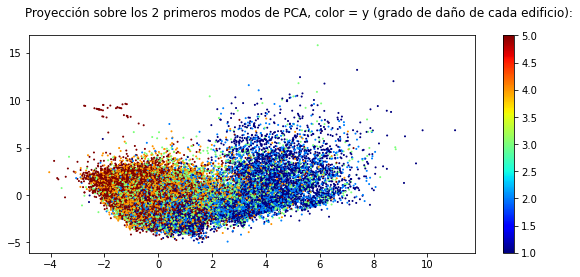

In [16]:
plt.figure(figsize=(10,4))
plt.scatter(np.transpose(X_pca)[0], np.transpose(X_pca)[1], c=y, s=1, cmap='jet')
plt.colorbar()

t = plt.suptitle('Proyección sobre los 2 primeros modos de PCA, color = y (grado de daño de cada edificio):')

Cada punto corresponde a una muestra. El PCA realiza una proyección del espacio de características sobre los 2 ejes de máxima varianza. Podemos ver que con sólo 2 ejes, es posible separar aproximadamente los grados de daño bajo de los grados de daño alto, pero una separación más fina es imposible.

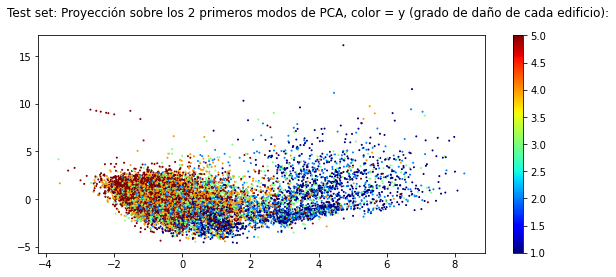

In [17]:
plt.figure(figsize=(10,4))
plt.scatter(np.transpose(X_test_pca)[0], np.transpose(X_test_pca)[1], c=y_test, s=1, cmap='jet')
plt.colorbar()

t = plt.suptitle('Test set: Proyección sobre los 2 primeros modos de PCA, color = y (grado de daño de cada edificio):')

## D. Comparación de diferentes clasificadores

Ahora podemos entrenar un modelo de aprendizaje automático y probarlo en el conjunto de datos de prueba. Para ello, "ajustaremos" (fit) los parámetros de una técnica de aprendizaje automático durante la fase de ajuste=entrenamiento=fitting, en la que se conocen tanto X como y. A continuación, predecimos para cada muestra del conjunto de pruebas cuál es el grado de daño estimado: entonces podemos evaluar la calidad de nuestro modelo comparándolo con el grado de daño real.

La clasificación consiste en predecir una *clase* (class), en oposición a un problema de regresión que consiste en predecir un *valor continuo*.

¿Cuántas clases tenemos en este problema? Consejo: puedes mirar la función np.unique().

In [18]:
classes = np.unique(y)
print('clases: ', classes)
N_classes = len(classes)
print('número de clases: ', N_classes)

clases:  [1 2 3 4 5]
número de clases:  5


Probaremos diferentes modelos de clasificación:
* Nearest Neighbors (Vecinos más cercanos)
* Linear Support Vector Machine (Máquina de vectores de soporte lineal)
* RBF Support Vector Machine (Máquina de vectores de soporte RBF)
* Random Forests (Bosques aleatorios)
* AdaBoost

Para obtener más información sobre ellos, le animo a consultar la documentación de sklearn: https://scikit-learn.org

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

Hagámoslo para un modelo, y luego realicemos las mismas operaciones para los demás modelos.

Primero, inicializamos la instancia del clasificador.

In [21]:
classifier_KNN = KNeighborsClassifier(3)

A continuación, entrenamos el modelo, dando al modelo las características X y su objetivo asociado (target) 'y' de todos los datos de entrenamiento.

In [22]:
classifier_KNN.fit(X, y)

KNeighborsClassifier(n_neighbors=3)

Por último, podemos evaluar nuestro modelo en datos no vistos, es decir, el conjunto de pruebas (test set). Y comparar las predicciones con la verdad básica (ground truth) y_test.

In [23]:
y_predict_KNN = classifier_KNN.predict(X_test)
print('Grados de daño predichos de las 5 primeras muestras (test set): ', y_predict_KNN[0:5])
print('Grados de daño real de las 5 primeras muestras (test set): ', np.array(y_test[0:5]))

Grados de daño predichos de las 5 primeras muestras (test set):  [1 5 4 4 3]
Grados de daño real de las 5 primeras muestras (test set):  [1 4 4 4 5]


 También podemos calcular la puntuación (score), es decir, el % de buenas predicciones.

In [23]:
from sklearn.metrics  import accuracy_score
score = accuracy_score(y_test, y_predict_KNN)
print(score)

0.39872282727551067


Tu turno! intenta hacer lo mismo con otros clasificadores: DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier, QuadraticDiscriminantAnalysis, support vector classifier ('SVC', usando un kernel lineal o un kernel rbf) por ejemplo. Al principio, use los parámetros por defecto, luego, puede intentar variarlos mirando primero lo que significan en la documentación de scikit-learn.

In [24]:
names = [
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
    "QDA",
    "Linear SVM",
    "RBF SVM"
]

classifiers = [
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    QuadraticDiscriminantAnalysis(),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1)
]

for name, clf in zip(names, classifiers):

    clf.fit(X[:5000], y[:5000])
    score = clf.score(X_test, y_test)
    print(name, ' score: ', score)


Decision Tree  score:  0.4129816734461794
Random Forest  score:  0.39859161089970696
AdaBoost  score:  0.424834886060447
QDA  score:  0.4055460788173031


/home/giffards/miniconda3/envs/tutorial2/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Linear SVM  score:  0.4227354240475878
RBF SVM  score:  0.38240825788391725


## E. Visualización de los resultados: matriz de confusión

Ahora tenemos la precisión de la puntuación=score (porcentaje de muestras de prueba correctamente clasificadas), pero ¿podemos entender mejor dónde están los errores? Para ello, una representación popular para los problemas de clasificación es una *matriz de confusión*. Veamos un ejemplo con el clasificador K-nearest neighbors ya entrenado.

In [24]:
import itertools

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(20, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label (etiqueta verdadera)')
    plt.xlabel('Predicted label (etiqueta estimada)')
    return 0

Normalized confusion matrix


0

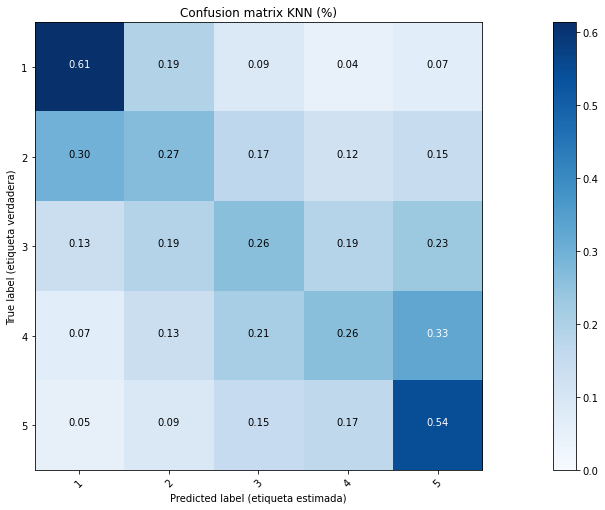

In [25]:
confusion_mat_KNN = confusion_matrix(y_test, y_predict_KNN)
plot_confusion_matrix(confusion_mat_KNN, classes=classes, normalize=True, title='Confusion matrix KNN (%)')

¿Cómo se lee una tabla de este tipo? Tomemos un ejemplo. A partir del primer valor, vemos que el 61% de las muestras de grado de daño 1 (DG1) se estimaron correctamente como DG1. Si seguimos en esta línea, podemos ver que el 19% de los DG1 se predijeron erróneamente como DG2, el 9% como DG3, etc. Un clasificador perfecto tendría unos en la diagonal y ceros en el resto.

Y ahora, ¡calculemos las matrices de confusión de los otros clasificadores!

Normalized confusion matrix


0

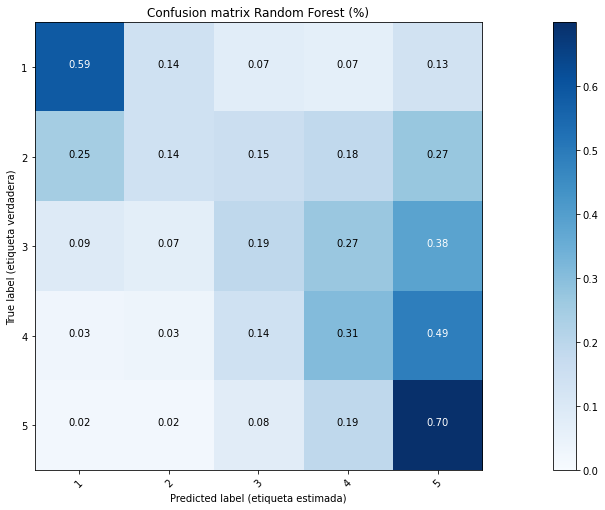

In [26]:
clf=RandomForestClassifier()
clf.fit(X[:5000], y[:5000])
y_predict_RF = clf.predict(X_test)
confusion_mat_RF = confusion_matrix(y_test, y_predict_RF)
plot_confusion_matrix(confusion_mat_RF, classes=classes, normalize=True, title='Confusion matrix Random Forest (%)')

## F. ¿Qué pasa con la regresión?

El problema de regresión consiste en estimar un valor continuo, a diferencia de las *clases*: estimar la magnitud de un terremoto es una regresión, mientras que estimar el tipo de terremotos (tectónico volcánico, temblor, etc.) es un problema de clasificación. Obsérvese que la estimación de un valor binario es también un problema de clasificación (como *¿es esta señal un terremoto o no?* hay dos clases, "sí" y "no", es decir, 1 o 0).

En este problema, también podríamos considerar el grado de daño como un problema de regresión. ¿Por qué? Porque el grado de daño es un objetivo *ordenado*, es decir, un DG1 está más cerca de un DG2 que de un DG3, por lo que un error de DG1 a DG2 es menor que de DG1 a DG3. Este no es el caso, por ejemplo, de los problemas *no ordenados*, como la clasificación de imágenes de gatos frente a perros frente a cerdos.

La principal diferencia de cálculo entre la regresión y la clasificación es la *pérdida* (loss), es decir, la función de coste que el algoritmo minimizará entre los objetivos de entrenamiento y las predicciones de entrenamiento. En una regresión, lo más frecuente es minimizar el error medio al cuadrado (mean squared error). Este es el caso de la regresión lineal, que quizá ya conozcas:

In [28]:
from sklearn.linear_model import LinearRegression
linear_regressor = LinearRegression()

linear_regressor.fit(X, y)
y_predict_lr = linear_regressor.predict(X_test)
print('Grados de daño predichos de las 5 primeras muestras: ', y_predict_lr[0:5])
print('Grados de daño real de las 5 primeras muestras: ', np.array(y_test[0:5]))

Grados de daño predichos de las 5 primeras muestras:  [1.99812202 4.19878995 4.09655942 4.11799885 4.07132679]
Grados de daño real de las 5 primeras muestras:  [1 4 4 4 5]


Note how the predictions are now continuous values. And now, the results will not be percentage of correct classifications, but a distance (here in 'damage grade')!

In [30]:
from sklearn.metrics  import mean_absolute_error
score = mean_absolute_error(y_test, y_predict_lr)
print('Linear regression: Mean absolute error = error medio al cuadrado (in DG): ', score)

Linear regression: Mean absolute error = error medio al cuadrado (in DG):  0.9089672440394612


Ahora entrena y estima el error medio de regresores más complejos, como el RandomForestRegressor, la regresión de vectores de soporte (SVR), o la interesante determinación automática de relevancia (ARD)... puede que necesites mirar la documentación de sklearn.

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ARDRegression

RF_regressor = RandomForestRegressor()

RF_regressor.fit(X, y)
y_predict_rf = RF_regressor.predict(X_test)
score = mean_absolute_error(y_test, y_predict_rf)
print('Random forest regression: Mean absolute error = error medio al cuadrado  (in DG): ', score)


Random forest regression: Mean absolute error = error medio al cuadrado  (in DG):  0.709898974291036




## Nota al margen: reemplazar valores perdidos en una base de datos

aquí hay un código en caso de que necesites reemplazar cualquier valor (en este caso, era -9.223372036854776, pero pueden ser ceros, o NaN, etc). 

In [ ]:
continuous_feats = ['age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq']

imp = SimpleImputer(missing_values=-9.223372036854776, strategy='mean')
X_train[continuous_feats].loc[:,:] = imp.fit_transform(X_train[continuous_feats].values)

enc = OrdinalEncoder()
X_train = enc.fit_transform(X_train)
X_test = enc.transform(X_test)
